<a href="https://colab.research.google.com/github/atharva0300/Learn-Cuda/blob/main/learn_cuda_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install nvcc4jupyter

In [5]:
%load_ext nvcc4jupyter

Source files will be saved in "/tmp/tmps78_qu1e".


In [6]:
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-7 60 --slave /usr/bin/g++ g++ /usr/bin/g++-7

update-alternatives: error: alternative path /usr/bin/gcc-7 doesn't exist


In [7]:
!gcc --version

gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



# GPU Computation Hierarchy and Matrix Spuaring Thread Divergence

## Launch onfiguration for huge data

In [8]:
%%cuda
#include<bits/stdc++.h>
#include<cuda.h>
using namespace std;

// Find the 2 issues in this code
// 1. accessing invalid memory locations as the size of the threads is greater

#define BLOCKSIZE 1024

__global__ void dbkernel(unsigned *vector){
    unsigned id = blockIdx.x * blockDim.x + threadIdx.x;
    vector[id] = id;  // access out of bounds
    // accessing invalid memory locations
}



int main(int nn , char *str[]){
    unsigned N = atoi(str[1]);
    unsigned *vector , *hvector;
    cudaMalloc(&vector, N * sizeof(unsigned));
    hvector = (unsigned*)malloc(N*sizeof(unsigned));

    unsigned nblocks = ceil(N/BLOCKSIZE); // needs floating point division

    printf("nblocks = %d\n" , nblocks);

    dbkernel<<<nblocks , BLOCKSIZE>>>(vector);
    cudaMemcpy(hvector , vector , N*sizeof(unsigned) , cudaMemcpyDeviceToHost);

    for(unsigned i=0;i<N;i++){
        printf("%4d" , hvector[i]);
    }

    return 0;
}

In [11]:
%%cuda
#include<bits/stdc++.h>
#include<cuda.h>
using namespace std;

// Solutions to the 2 issues pointed abovve

#define BLOCKSIZE 1024

__global__ void dbkernel(unsigned *vector , unsigned vectorsize){
    unsigned id = blockIdx.x * blockDim.x + threadIdx.x;
    if(id < vectorsize){
        vector[id] = id;  // adding a condition to check the out of bound access
    }
}



int main(int nn , char *str[]){
    unsigned N = atoi(str[1]);
    unsigned *vector , *hvector;
    cudaMalloc(&vector, N * sizeof(unsigned));
    hvector = (unsigned*)malloc(N*sizeof(unsigned));

    unsigned nblocks = ceil((float)N/BLOCKSIZE); // needs floating point division
    // convertign the N value to float before the division

    printf("nblocks = %d\n" , nblocks);

    dbkernel<<<nblocks , BLOCKSIZE>>>(vector , N);
    cudaMemcpy(hvector , vector , N*sizeof(unsigned) , cudaMemcpyDeviceToHost);

    for(unsigned i=0;i<N;i++){
        printf("%4d" , hvector[i]);
    }

    return 0;
}

In [15]:
%%cuda
#include<bits/stdc++.h>
#include<cuda.h>
#include<chrono>
#include<ctime>
using namespace std;

// cpu function for matrix squaring
void squarecpu(unsigned *matrix , unsigned *result , unsigned matrixsize = 64){
      for(unsigned i=0;i<matrixsize;i++){
          for(unsigned j=0;j<matrixsize;j++){
              for(unsigned k=0;k<matrixsize;k++){
                  result[i*matrixsize + j] += matrix[i*matrixsize + k] * matrix[k*matrixsize + j];
              }
          }
      }
}

// gpu function ( kernel function ) for matrix squareing
__global__ void square(unsigned *matrix, unsigned *result , unsigned matrixsize){
    unsigned id = blockIdx.x * blockDim.x + threadIdx.x;
    for(unsigned j=0;j<matrixsize;j++){
        for(unsigned k=0;k<matrixsize;k++){
            result[id*matrixsize+j] += matrix[id * matrixsize + k] * matrix[k * matrixsize + j];
        }
    }
}

// the reduction in time of the GPU is directly proportional to the parallelism of the GPU
// the number of threads used
// the amount of threads is 64

// gpu function ( kernel function ) for matrix squareing
// with threads
__global__ void square2(unsigned *matrix, unsigned *result , unsigned matrixsize){
    unsigned id = blockIdx.x * blockDim.x + threadIdx.x;
    unsigned i = id / matrixsize;
    unsigned j = id % matrixsize;
    for(unsigned k=0;k<matrixsize;k++){
        result[id*matrixsize+j] += matrix[id * matrixsize + k] * matrix[k * matrixsize + j];
    }
}

// the amount of threads in square2 function is 64*64 -> 4096 threads ( N*N threads )
// this version will be faster

// performance of square2 > squarecpu > square functions
// squarecpu > square function because in the square() function the threads are poorly
// utilized

// the above square2 function, the performance of the GPU will be greater

int main(){


  return 0;
}

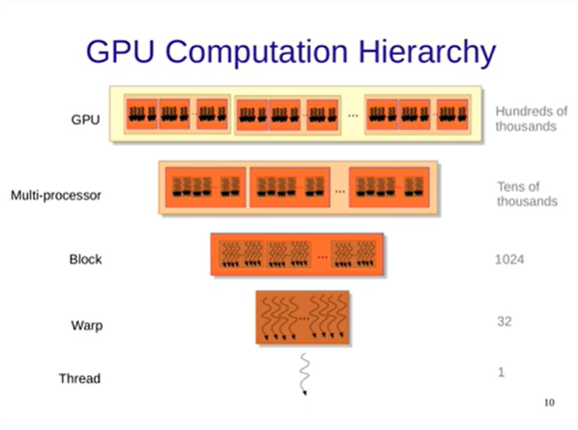

The GPU runs is based on the SIMD architecture ( Single instruction, multiple data )

1. 1 warp has 32 threads
2. 1 block as 1024 threads. Hence 1 block has 1024/32 -> 32 warps
3. 1 multiprocessors has tens of thousands of threads
4. 1 GPU has hundreds of thousands of threads

Shared memory is available for the threads of hte memory. This memory is available per block. It is very fast. It is basically hte L1 cache. the threads inside 1 thread-block can make use of the shared memory. Multiple such thread-blocks are assigned to streaming multiprocessors.
A streaming multiprocessor can have 1-5 thread-bloccs assigned to it at a particulr time

NOTE : A block when once assigned to a streaming multiprocessor cannot go to another streaming multiprocessor.

Multiple such streaming multiprocessors forms a GPU

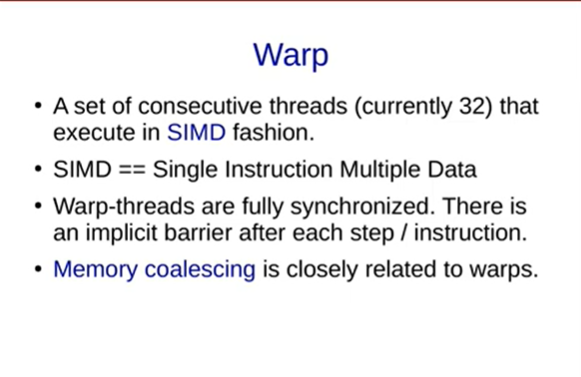

1. Warp threads are fully synchronized.
2. it is a misconception that all threads in a GPU execute in lock-step. Lock-step execution is true for threads only within a warp.

# Warp with conditions

In [9]:
__global__ void dbkernel(unsigned *vector, unsigned vectorisze){
    unsinged id = blockIdx.x * blockDim.x + threadIdx.x
    if(id%2){
        // odd it threads
        // odd id threads will execute these statements
        // even id threads will have to wait
        vector[id] = id;
    }else{
        // even id threads
        // even id threads will execute these statements
        // and odd id threads will have to wait
        vector[id] = vectorsize * vectorsize;
        vector[id]++;
    }
}

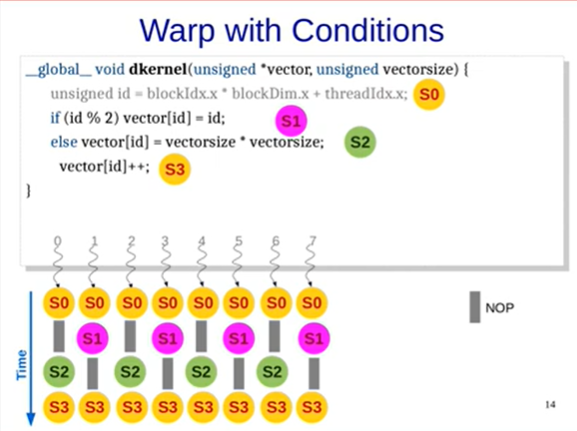

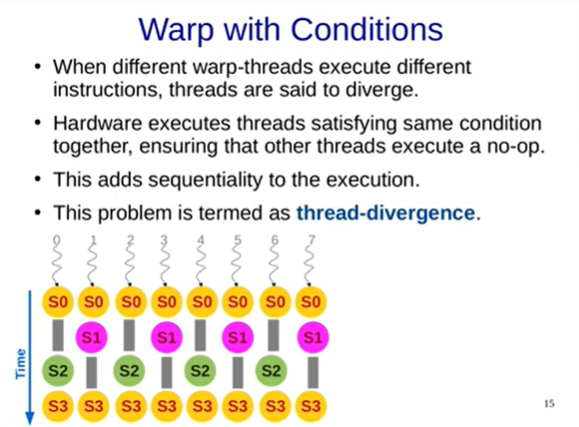

In [ ]:
__global__ void dbkernel(unsigned *vector, unsigned vectrosize){
    unsigned id = blockIdx.x * blockDim.x + threadIdx.x;
    for(unsigned i=0;i<id;i++){
        vector[id] += i;
    }
}

// will this code diverge ?
// yes, because the size of the loop is dependent on the id and id is variable
// depending on the id of thread, each loop will do variable amount of work
// all the threads should wait for the last thread which will execute this loop from 0 to 30, all the rest
// of the threads will have to wait for the last thread 30 ( or the thread with the longest amount of computation )

In [ ]:
__global__ void dbkernel(unsigned *vector, unsigned vectorsize ){
    unsigned id = blockIdx.x * blockDim.x + threadIdx.x;
    if(id%2){
        vector[id] = id;
    }else if(vector[id]%2){
        vector[id] = id /2;
    }else{
        vector[id] = id*2;
    }
}

// vector is initialized to {0,1,2,3,....}
// does this code diverge further ? as compared to the code : https://colab.research.google.com/drive/1VgqZ_tAj9svch4yv1o-6ISLQR_Z5uyQp#scrollTo=Au1k4B_I-ilE&line=12&uniqifier=1

// NO

// the id of the vector will be 0,1,2,3,...
// so the else if condition will never get satisfied for any threads, hence all
// these even number of threads will execute the else condition
// this is the same as the other code

# Thread Divergence

1. Sunce thread-divergence makes execution sequential, conditions are evil in the kernel codes ?

In [ ]:
if( vectorsize < N ){
    s1;
    else s2;
}

// NO
// Condition but no divergence
// because each and every thread is executing the same statement
// the computation is not distributed

In [ ]:
Then, conditions evaluating to different truth-values are evil ?

if( id / 32) else{
    s1;
    else s2;
}

// different truth-values but no divergence

# Takeaway
1. Conditions are not bad.
They are evaluating to different truth-values is also not bad.
They evaluating to different truth-values for warp-threads is bad.

In [ ]:
// Classwork
// Rewrite the following program fragment to remove thread-divergence

assert(x==y || x==z);
if(x==y){
    x=z;
}else{
    x=y;
}

The above code may lead to divergence.

In [ ]:
assert(x==y || x==z);
x = y + z - x;

// when x=y, then x will become z
// when x=z, then x will become y